In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from res_manager import ResultManager

In [4]:
from PIL import Image
import time
import os
import pickle
from collections import defaultdict
from io import BytesIO

In [5]:
rm = ResultManager('results')

In [6]:
rm.print_meta_info()

+---------+---------------------------+--------------+-------------+----------+
| Data ID |            Name           |    Topic     |     Type    | Versions |
+---------+---------------------------+--------------+-------------+----------+
|    1    |        flat q perf        | measurements | defaultdict |    1     |
|    2    |        min uv perf        | measurements | defaultdict |    1     |
|    3    |       orig jpeg perf      | measurements | defaultdict |    1     |
|    4    |    measurement imagenet   | measurements | defaultdict |    3     |
|    5    |        robust dict        | measurements | defaultdict |    1     |
|    6    |      robust dict 22k      | measurements | defaultdict |    2     |
|    7    |      jpeg_size_diffQ      | measurements |     list    |    1     |
|    8    |        performance        |  AgentTest   | defaultdict |    8     |
|    9    | performance_banchmark_q80 |  AgentTest   | defaultdict |    1     |
|    10   |        Q_agent_eval       | 

# Top1 Accuracy and size upon JPEG qualities

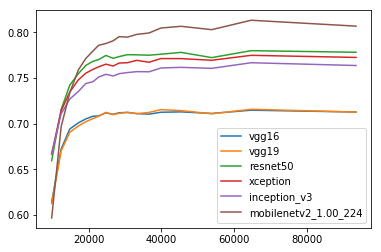

In [6]:
origin_jpeg_perf = rm.load(3)
for net, prop in origin_jpeg_perf.items():
    plot(prop['aver_sizes'], prop['accuracies'], label=net)

legend()

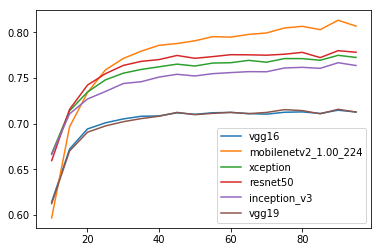

In [7]:
for net, prop in origin_jpeg_perf.items():
    plot(prop['qualities'], prop['accuracies'], label=net)

legend()

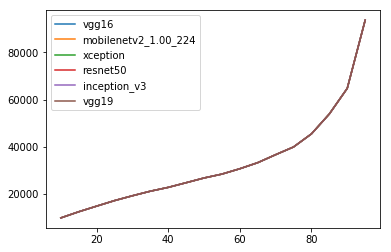

In [8]:
for net, prop in origin_jpeg_perf.items():
    plot(prop['qualities'], prop['aver_sizes'], label=net)

legend()

# Accuracy and size upon different q-tables

In [9]:
data = rm.load(1)

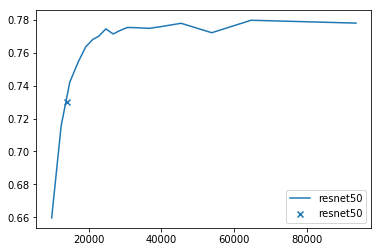

In [10]:
convention_jpeg_data = rm.load(3)
# for net, prop in convention_jpeg_data.items():
net = 'resnet50'

prop = convention_jpeg_data[net]
plot(prop['aver_sizes'], prop['accuracies'], label=net)
prop = data[net]
scatter(prop['aver_size'], prop['accuracy'], label=net, marker='x')

legend()

In [11]:
data

defaultdict(dict,
            {'inception_v3': {'accuracy': 0.7149, 'aver_size': 14087.51225},
             'mobilenetv2_1.00_224': {'accuracy': 0.7093,
              'aver_size': 14087.51225},
             'resnet50': {'accuracy': 0.7302, 'aver_size': 14087.51225},
             'vgg16': {'accuracy': 0.681, 'aver_size': 14087.51225},
             'vgg19': {'accuracy': 0.67595, 'aver_size': 14087.51225},
             'xception': {'accuracy': 0.72675, 'aver_size': 14087.51225}})

# Generate dataset for robustness regressor

## Generate

In [6]:
def gen_sample_set(imagenet_data_path, samples_per_class):
    image_paths = []
    image_labels = []

    img_classes = os.listdir(imagenet_data_path)
    for img_class in img_classes:
        for image_name in np.random.choice(os.listdir("%s/%s" % (imagenet_data_path, img_class)),
                                           size=samples_per_class):
            sample_image_path = ("%s/%s/%s" % (imagenet_data_path, img_class, image_name))
            image_label = imagenet_label2class[image_name.split('_')[0]]

            image_paths.append(sample_image_path)
            image_labels.append(image_label)
    return image_paths, image_labels

def compress_Q(img, Q):
    f = BytesIO()
    img.save(f, format="JPEG", quality=Q)
    return Image.open(f)

def max_continous_idx(l):
    sums = []
    ids = []
    curr_sum = 0
    for idx, item in enumerate(l):
        if item == 1:
            curr_sum += 1
            if curr_sum == len(l):
                return len(l) - 1
        else:
            sums.append(curr_sum)
            curr_sum = 0
            ids.append(idx -  1)
    return np.array(ids)[np.argmax(sums)]

In [7]:
from keras.applications import InceptionV3
from keras.utils.np_utils import to_categorical
from imagenet import imagenet_label2class
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [8]:
sample_paths, sample_labels = gen_sample_set('/home/hsli/gnode02/imagenet-data/train/', 22)

In [9]:
model_labels = to_categorical(sample_labels, 1000)

In [10]:
model = InceptionV3()
model.compile('adam', 'categorical_crossentropy', ['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
robust_dict = defaultdict(list)
measurement_dict = defaultdict(list)
for idx, path in enumerate(sample_paths):
    if idx % 100 == 0:
        print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), end='\t')
        print(idx)
    model_label = np.expand_dims(model_labels[idx], axis=0)
    top5_list = []
    top1_list = []
    img = Image.open(path).convert("RGB")
    for i in arange(100, 0, -1):
        model_input_data = preprocess_input(np.expand_dims(np.asarray(compress_Q(img, int(i)).resize((299, 299)), dtype=np.float32), axis=0))
        loss, top1, top5 = model.evaluate(model_input_data, model_label, verbose=0)
        top5_list.append(int(top5))
        top1_list.append(int(top1))
    minimal_stable_q = 100 - max_continous_idx(top5_list)
    measurement_dict['paths'].append(path)
    measurement_dict['top1_upon_q'].append(top1_list)
    measurement_dict['top5_upon_q'].append(top5_list)
    measurement_dict['minimal_stable_q'].append(minimal_stable_q)
    
    if minimal_stable_q < 100:
        robust_dict['paths'].append(path)
        robust_dict['robustness'].append(minimal_stable_q)
    

2019-02-02 19:20:39	0
2019-02-02 19:25:28	100
2019-02-02 19:30:24	200
2019-02-02 19:35:27	300
2019-02-02 19:40:11	400
2019-02-02 19:45:03	500
2019-02-02 19:50:04	600
2019-02-02 19:55:31	700
2019-02-02 20:00:33	800
2019-02-02 20:05:25	900
2019-02-02 20:10:03	1000
2019-02-02 20:14:48	1100
2019-02-02 20:19:47	1200
2019-02-02 20:24:35	1300
2019-02-02 20:29:07	1400
2019-02-02 20:34:13	1500
2019-02-02 20:39:02	1600
2019-02-02 20:43:50	1700
2019-02-02 20:48:53	1800
2019-02-02 20:53:45	1900
2019-02-02 20:58:54	2000
2019-02-02 21:04:32	2100
2019-02-02 21:09:14	2200
2019-02-02 21:13:51	2300
2019-02-02 21:19:09	2400
2019-02-02 21:23:47	2500
2019-02-02 21:28:37	2600
2019-02-02 21:33:28	2700
2019-02-02 21:38:23	2800
2019-02-02 21:43:05	2900
2019-02-02 21:48:00	3000
2019-02-02 21:53:02	3100
2019-02-02 21:57:29	3200
2019-02-02 22:02:03	3300
2019-02-02 22:06:47	3400
2019-02-02 22:11:52	3500
2019-02-02 22:17:06	3600
2019-02-02 22:21:47	3700
2019-02-02 22:26:37	3800
2019-02-02 22:31:14	3900
2019-02-02 2

In [ ]:
rm.save(measurement_dict, name="measurement imagenet", topic="measurements", 
        comment="top1 and top5 acc and upon different quality in random 22k imgs on inceptionv3")

In [ ]:
rm.save(robust_dict, name="robust dict 22k", topic="measurements",
        comment="robustness in random 22k imgs upon different q on inceptionv3")

In [ ]:
rm.print_meta_info()

## Observe robustness and image

In [8]:
robust_dict = rm.load(6)

In [9]:
robust_dict.keys()

dict_keys(['paths', 'robustness'])

In [10]:
robustness = np.array(robust_dict['robustness'])

In [11]:
np.mean(robustness)

5.510049333089714

In [12]:
np.std(robustness)

10.880223404647587

In [13]:
np.median(robustness)

3.0

In [14]:
len(robustness)

21892

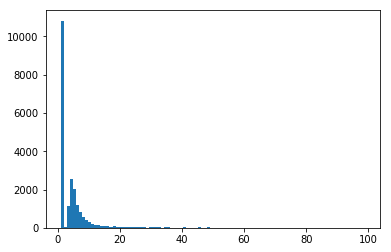

In [15]:
_ = hist(robustness, bins=100)

In [15]:
len(np.where(robustness < 20)[0]) / len(np.where(robustness > 20)[0])

21.258919469928646

In [16]:
len(np.where(robustness < 20)[0]) / len(robustness)

0.952631098118034

In [17]:
non_robust_paths = np.array(robust_dict['paths'])[np.where(robustness > 80)]

In [18]:
robust_paths = np.array(robust_dict['paths'])[np.where(robustness == 1)]

In [19]:
len(robust_dict['paths'])

21892

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 15.0)

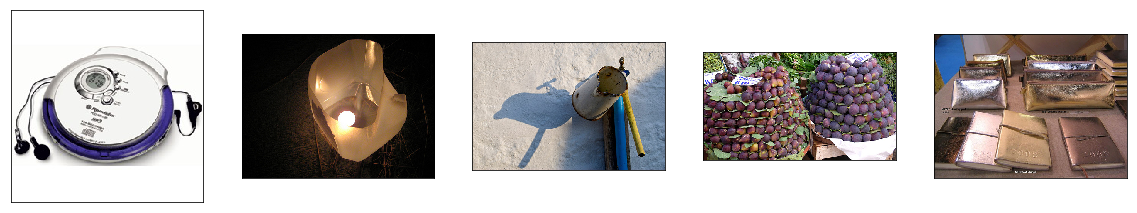

In [21]:
for idx, path in enumerate(non_robust_paths[10:15]):
    subplot(1,5,idx+1)
    imshow(Image.open(path))
    xticks([])
    yticks([])

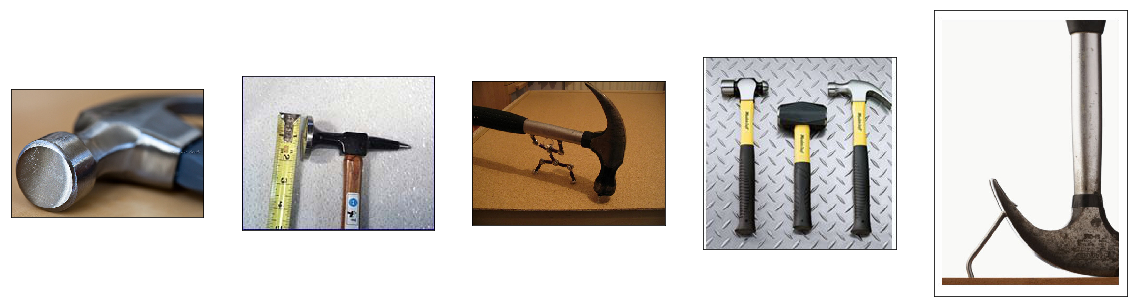

In [22]:
for idx, path in enumerate(robust_paths[15:20]):
    subplot(1,5,idx+1)
    imshow(Image.open(path))
    xticks([])
    yticks([])

## Observe robustness and DCT features

In [38]:
from image_pipelines import split_88

Using TensorFlow backend.


In [39]:
import cv2

In [40]:
def get_single_features(image):
    y, u, v = image.split()
    channel = np.asarray(y.resize((512, 512)))
    # split and shift
    blocks = split_88(channel) - 128
    # DCT
    dct_blocks = np.array([cv2.dct(block) for block in blocks])

    # --- Extract features --- #
    dct_std_matrix = np.std(dct_blocks, axis=0, ddof=1)
#     dct_std_matrix = np.mean(dct_blocks, axis=0)

    return dct_std_matrix

In [48]:
plt.rcParams['figure.figsize'] = (20.0, 2.5)

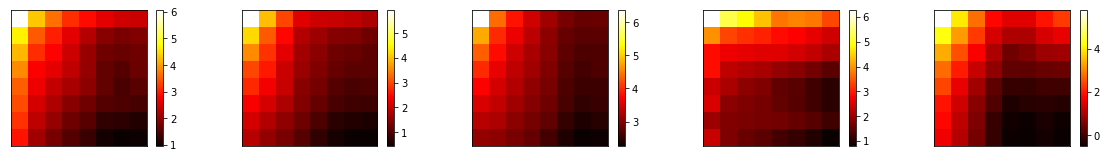

In [52]:
for idx, path in enumerate(non_robust_paths[:5]):
    subplot(1,5,idx+1)
    img = Image.open(path).convert("RGB").resize((512, 512))
    feature_map = get_single_features(img)
    feature_map = np.log(feature_map)
    imshow(feature_map, cmap='hot')
#     _ = hist(get_single_features(img).flatten(), bins=100)
    colorbar()
    xticks([])
    yticks([])

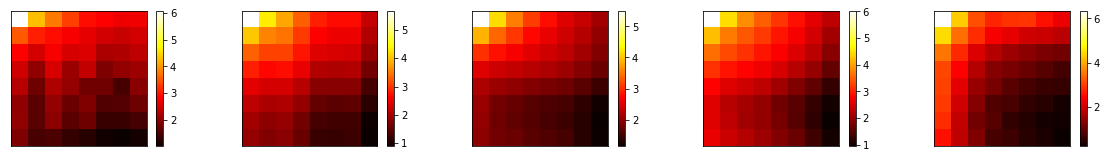

In [50]:
for idx, path in enumerate(robust_paths[:5]):
    subplot(1,5,idx+1)
    img = Image.open(path).convert("RGB").resize((512, 512))
    feature_map = get_single_features(img)
    feature_map = np.log(feature_map)
    imshow(feature_map, cmap='hot')
#     _ = hist(get_single_features(img).flatten(), bins=100)
    colorbar()
    xticks([])
    yticks([])

# Check new top5 robustness predictor

In [6]:
from keras.models import load_model
from keras.applications.mobilenetv2 import preprocess_input

Using TensorFlow backend.


In [7]:
robust_predictor = load_model('/home/hsli/Workshop/FastInference/checkpoints/mobilenetv2_regressor.weights.10.hdf5')

In [8]:
robust_dict = rm.load(5)

In [19]:
robust_dict.keys()

dict_keys(['robustness', 'paths'])

In [31]:
sample_paths = [path for path in rm.load(5)['paths'][-200:]]

In [32]:
sample_labels = rm.load(5)['robustness'][-200:]

In [33]:
sample_features = np.array([preprocess_input(np.asarray(Image.open(path).convert("RGB").resize((224, 224)), dtype=np.float32)) for path in sample_paths])

In [34]:
sample_features.shape

(200, 224, 224, 3)

In [35]:
predict_res = robust_predictor.predict(sample_features, batch_size=4, verbose=1)

200/200 [==============================] - 1s 4ms/step


In [36]:
np.round(predict_res.flatten()).astype(np.uint8)

array([ 6,  9,  3,  2,  4, 10,  7,  6,  6,  6,  4,  4,  1, 13, 22,  4, 20,
        9, 19,  1,  4,  3,  4, 11,  5,  5,  1,  2,  4,  1,  2,  2,  5, 12,
        2,  3,  4,  3,  3,  2,  8, 11,  3,  4, 14,  9,  7,  6,  1, 10,  2,
        1,  7,  1,  4,  7,  5,  9, 16, 11,  7, 14,  5, 12,  1,  1,  3,  2,
        5,  2, 12,  6,  3, 14,  3,  6,  2,  2,  3,  2,  1,  7, 25, 14, 10,
        6,  8, 12, 18,  5,  1,  5,  2,  3,  4,  7,  1,  9,  8,  1,  1,  2,
        3,  8,  4,  4,  1,  6,  3,  7,  6,  1,  1,  1,  1,  1,  2,  5,  2,
       12,  4, 23,  4, 13,  1,  2,  2,  2,  4,  4,  5,  3,  5,  4,  3,  2,
        5, 11, 18, 15, 14, 10,  4,  3,  8,  3,  5,  4,  4,  9,  2,  8,  3,
        2, 13,  5,  4, 12,  1,  6,  5,  1,  3,  3,  6,  6,  8,  6,  4,  6,
       10,  1,  6,  2,  3,  4,  2,  3, 10,  2,  2,  1,  1,  1,  1,  2,  2,
        1,  3,  4,  2,  1, 12,  1,  0, 11,  2,  6,  1, 10], dtype=uint8)

In [37]:
np.array(sample_labels)

array([ 1, 11,  3,  5,  3, 10, 20,  4,  1, 12,  1,  5,  9,  1,  6,  1, 33,
        1,  1,  1,  1,  3,  1,  8,  1,  7,  1,  1,  3,  1,  1,  1,  5,  1,
        4,  4,  5,  4,  1,  1,  7,  1,  1, 12,  4,  6,  4,  7,  1,  7, 12,
        5,  8,  4,  1,  7,  1,  1,  1,  5,  1,  9,  9, 65,  1,  1,  1,  4,
       11,  1,  5,  5,  4, 90,  4,  4,  1,  4,  1,  1,  4,  4,  1,  1,  1,
        1,  1,  1,  1, 46,  4, 33,  6,  5,  1,  3,  3,  1, 19,  1,  1,  5,
        1,  4, 52, 27,  1,  1,  5,  1,  6,  1,  1,  4,  7,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  4,  9,  4,  4, 12,
       14,  1,  3,  1,  1,  4, 13,  1,  1,  9,  3,  4,  4,  5,  1,  5,  5,
        5, 44, 12,  6,  6,  5,  5,  6,  4,  6,  4, 16,  3,  8,  4,  1, 13,
        5,  1,  1,  1,  1,  1,  1,  1,  4,  5,  6,  1,  1,  3,  1,  3,  5,
        3,  4,  1,  5,  1, 26, 10,  1, 81,  1,  1,  1, 85])

# Fit accuracy and size curve

In [6]:
from scipy.optimize import curve_fit

## plot size upon different quality

### Regenerate fine-grained data size set

In [7]:
from multiprocessing import Pool
from functools import partial

def gen_sample_set(imagenet_data_path, samples_per_class):
    image_paths = []
    image_labels = []

    img_classes = os.listdir(imagenet_data_path)
    for img_class in img_classes:
        for image_name in np.random.choice(os.listdir("%s/%s" % (imagenet_data_path, img_class)),
                                           size=samples_per_class):
            sample_image_path = ("%s/%s/%s" % (imagenet_data_path, img_class, image_name))
            
            image_paths.append(sample_image_path)
    return image_paths

def size_Q(img, Q):
    f = BytesIO()
    img.save(f, format="JPEG", quality=Q)
    return len(f.getvalue())

In [8]:
def single_process(path, Q):
    return size_Q(Image.open(path).convert("RGB"), int(Q))

sample_set = gen_sample_set('/home/hsli/gnode02/imagenet-data/train/', 20)
pool = Pool(processes=10)
aver_size_list = []
for i in arange(1, 101, 1):
    print("Parsing %s" % i)
    sizes = pool.map(partial(single_process, Q=int(i)), sample_set)
    aver_size_list.append(np.mean(sizes))

FileNotFoundError: [Errno 2] No such file or directory: '/home/hsli/gnode02/imagenet-data/train/'

In [ ]:
rm.print_meta_info()

### JPEG's compressed data size measured on 2W images

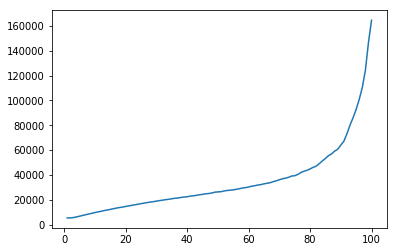

In [9]:
qualities = [i for i in np.arange(1, 101, 1)]
sizes = rm.load(7)
plot(qualities, sizes)

## plot top5 accuracy upon different quality (InceptionV3)

In [7]:
data = rm.load(4)

In [8]:
top5_data = np.array(data['top5_upon_q'])
top5_upon_q_list = []
for i in range(100):
    top5_upon_q_list.append(sum(top5_data[:, i]) / len(top5_data[:, i]))

Text(0.5, 1.0, "InceptionV3's top5 accuracy upon Q")

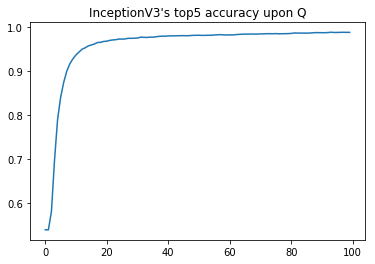

In [9]:
plot(top5_upon_q_list[::-1])
title("InceptionV3's top5 accuracy upon Q")

## Try to fit the data size curve

In [10]:
all_qualities = [i for i in np.arange(1, 101, 1)]
all_sizes = rm.load(7)

### Linear phase

In [11]:
qualities = all_qualities[:70]
sizes = all_sizes[:70]

In [12]:
def fun_lin(x, a, b):
    return a * x + b

In [13]:
popt_lin, pcov = curve_fit(fun_lin, qualities, sizes)

In [14]:
fit_lin = [fun_lin(i, *popt_lin) for i in qualities]

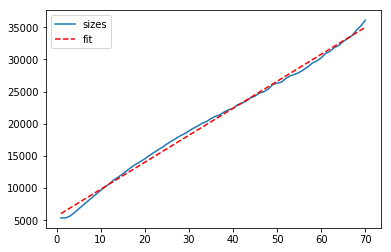

In [15]:
plot(qualities, sizes, label='sizes')
plot(qualities, fit_lin, 'r--', label='fit')
legend()

In [16]:
popt_lin

array([ 419.87965769, 5600.59477504])

### Exp phase

In [17]:
def fun_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

In [18]:
p0, _ = curve_fit(fun_exp, all_qualities, all_sizes)

/home/hsli/anaconda2/envs/tensorflow18_p35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [19]:
qualities = all_qualities[60:]
sizes = all_sizes[60:]

In [20]:
popt_exp, pcov = curve_fit(fun_exp, qualities, sizes, p0=p0)

In [21]:
fit_exp = [fun_exp(i, *popt_exp) for i in qualities]

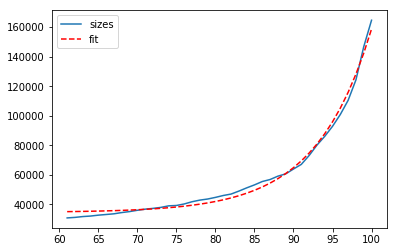

In [22]:
plot(qualities, sizes, label='sizes')
plot(qualities, fit_exp, 'r--', label='fit')
legend()

In [23]:
popt_exp

array([ 9.23157463e-02, -1.41105100e-01,  3.46626355e+04])

### Overall fitting

In [24]:
def fit_size(x, popt_lin, popt_exp):
    if x < 70:
        return fun_lin(x, *popt_lin)
    else:
        return fun_exp(x, *popt_exp)

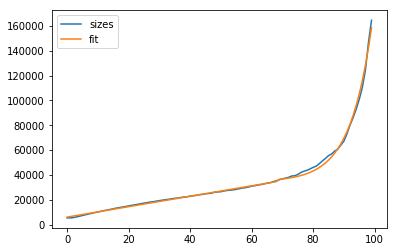

In [25]:
plot(all_sizes, label='sizes')
plot([fit_size(i, popt_lin, popt_exp) for i in np.arange(1, 101, 1)], label='fit')
legend()

In [26]:
fit_size(70, popt_lin, popt_exp)

36461.33001697675

### Inverse function

In [27]:
def _fit_size(y, popt_lin, popt_exp):
    if y < 36461.33:
        a, b = popt_lin
        return (y-b) / a
    else:
        a, b, c = popt_exp
        return -np.log((y-c)/a)/b

## Try to fit the accuracy curve

In [28]:
all_qualities = [i+1 for i in range(100)]
all_accuracies = top5_upon_q_list[::-1]

### Sigmoid phase

In [29]:
qualities = all_qualities[:40]
accuracies = all_accuracies[:40]

In [30]:
def fun_sigm(x, a, b):
    return a / (1 + np.e ** (-b * x))
#     return a * np.log(b*x)

In [31]:
popt_sigm, pcov = curve_fit(fun_sigm, qualities, accuracies)

In [32]:
fit_sigm = [fun_sigm(i, *popt_sigm) for i in qualities]

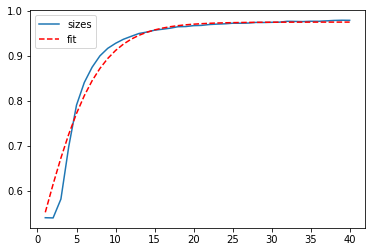

In [33]:
plot(qualities, accuracies, label='sizes')
plot(qualities, fit_sigm, 'r--', label='fit')
legend()

In [34]:
popt_sigm

array([0.97472286, 0.26697622])

In [35]:
fun_sigm(30, *popt_sigm)

0.9743990113212638

### Log phase

In [36]:
qualities = all_qualities[30:]
accuracies = all_accuracies[30:]

In [37]:
def fun_log(x, a, b, c):
    return a * np.log(b * x) + c

In [38]:
popt_log, pcov = curve_fit(fun_log, qualities, accuracies)

/home/hsli/anaconda2/envs/tensorflow18_p35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [39]:
fit_log = [fun_log(i, *popt_log) for i in qualities]

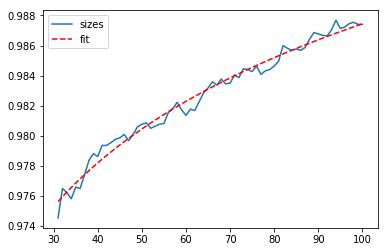

In [40]:
plot(qualities, accuracies, label='sizes')
plot(qualities, fit_log, 'r--', label='fit')
legend()

In [41]:
popt_log

array([0.01008557, 0.62836098, 0.94568482])

### Overall fitting

In [42]:
def fit_acc(x, popt_sigm, popt_log):
    if x < 30:
        return fun_sigm(x, *popt_sigm)
    else:
        return fun_log(x, *popt_log)

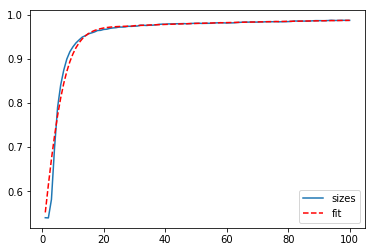

In [43]:
plot(all_qualities, all_accuracies, label='sizes')
plot(all_qualities, [fit_acc(q, popt_sigm, popt_log) for q in all_qualities], 'r--', label='fit')
legend()

In [44]:
fit_acc(30, popt_sigm, popt_log)

0.9753016730925379

### Inverse function

In [45]:
def _fit_acc(y, popt_sigm, popt_log):
    if y < 0.9753:
        a, b = popt_sigm
        return np.log(y/(a-y)) / b
    else:
        a, b, c = popt_log
        return np.e ** ((y - c) / a) / b

In [46]:
_fit_acc(0.98, popt_sigm, popt_log)

47.80087026548005

In [47]:
popt_log

array([0.01008557, 0.62836098, 0.94568482])

In [48]:
pcov

array([[ 2.85398277e-08,  5.30611173e-02, -8.51767223e-04],
       [ 5.30611078e-02,  1.69118555e+08, -2.71445400e+06],
       [-8.51767070e-04, -2.71445400e+06,  4.35686109e+04]])

## Pareto

In [49]:
pareto_err = []
pareto_size = []
for acc in all_accuracies:
    q = all_qualities[all_accuracies.index(acc)]
    pareto_err.append(1-acc)
    pareto_size.append(all_sizes[q])

Text(0, 0.5, 'Data size')

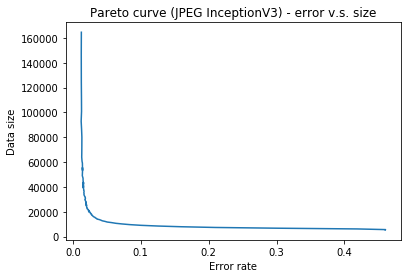

In [50]:
plot(pareto_err, pareto_size)
title("Pareto curve (JPEG InceptionV3) - error v.s. size")
xlabel("Error rate")
ylabel("Data size")

### Load image complexity predictor's performance

In [95]:
rm.print_meta_info()

+---------+---------------------------+--------------+-------------+----------+
| Data ID |            Name           |    Topic     |     Type    | Versions |
+---------+---------------------------+--------------+-------------+----------+
|    1    |        flat q perf        | measurements | defaultdict |    1     |
|    2    |        min uv perf        | measurements | defaultdict |    1     |
|    3    |       orig jpeg perf      | measurements | defaultdict |    1     |
|    4    |    measurement imagenet   | measurements | defaultdict |    3     |
|    5    |        robust dict        | measurements | defaultdict |    1     |
|    6    |      robust dict 22k      | measurements | defaultdict |    2     |
|    7    |      jpeg_size_diffQ      | measurements |     list    |    1     |
|    8    |        performance        |  AgentTest   | defaultdict |    8     |
|    9    | performance_banchmark_q80 |  AgentTest   | defaultdict |    1     |
|    10   |        Q_agent_eval       | 

In [7]:
performances = rm.load(10)
banchmark = rm.load(9)

In [8]:
accs = performances['accuracies']
sizes = performances['batch_sizes']
bm_accs = banchmark['agent_acc']
bm_sizes = banchmark['agent_size']

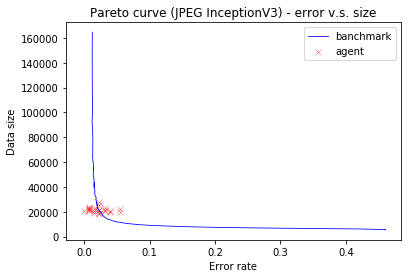

In [98]:
# scatter(pareto_err, pareto_size, label="banchmark", marker='x', c='b', linewidth=0.3)
plot(pareto_err, pareto_size, label="banchmark", c='b', linewidth=0.8)
title("Pareto curve (JPEG InceptionV3) - error v.s. size")
xlabel("Error rate")
ylabel("Data size")

scatter(1-np.array(accs), sizes, marker='x', c='r', linewidth=0.3, label="agent")
# scatter(1-np.array(bm_accs), bm_sizes, marker='x', c='g', linewidth=0.3, label="banchmark")
legend()
# ylim(0, 20000)

In [9]:
finegrain_sizes = performances['sizes']
finegrain_bm_sizes = performances['bm_sizes']

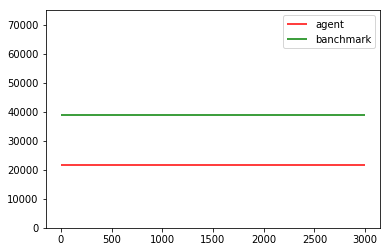

In [18]:
# plot(finegrain_sizes[:50], label='agent')
# plot(finegrain_bm_sizes[:50], label='banchmark')
hlines(xmin=0, xmax=len(finegrain_sizes), y=np.mean(finegrain_sizes), color='r', label='agent')
hlines(xmin=0, xmax=len(finegrain_bm_sizes), y=np.mean(finegrain_bm_sizes), color='g', label='banchmark')
ylim(0, 75000)
legend()

In [11]:
np.mean(accs)

0.9777715773809524